
#Neuroguard, Machine learning for intracranial pressure monitoring

##Specific objectives
1. development a algoritm

##Sections of the project
1. Set up the environment
2. Download relevant databases and resources
3. Preprocessing
4. Create new development space with SAM
5. Assign SAM configuration
6. Testing on random images for segmentation
7. Check out our WEB page


<a id="1.setup"></a>
#1. Set Up the environment


In [1]:
!gdown --id 1RplOOrelIOycetRtEpoYrLmFZLtsJZUX
!7z x SAM_workshop_data2.zip

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

!{sys.executable} -m pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!{sys.executable} -m pip install lvis
!{sys.executable} -m pip install lvis-api/.
!{sys.executable} -m pip install tqdm

from copy import deepcopy
import logging
from collections import defaultdict
from collections import OrderedDict

from lvis.lvis import LVIS
import pycocotools.mask as mask_utils
import datetime

from tqdm import tqdm
import json

from lvis import LVIS, LVISVis, LVISResults, LVISEval

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1RplOOrelIOycetRtEpoYrLmFZLtsJZUX
From (redirected): https://drive.google.com/uc?id=1RplOOrelIOycetRtEpoYrLmFZLtsJZUX&confirm=t&uuid=040bbaff-fd93-4d27-bf11-371d001013f5
To: /content/SAM_workshop_data2.zip
100% 3.26G/3.26G [00:42<00:00, 76.0MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 3259615482 bytes (3109 MiB)

Extracting archive: SAM_workshop_data2.zip
 80% 4096 Open              --
Path = SAM_workshop_data2.zip
Type = zip
Physical Size = 325961

#2. Download relevant databases and resources

In [2]:
!wget -O kaggle.json https://raw.githubusercontent.com/aarevalom0/NeuroGuard/refs/heads/main/kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Files of Kaggle competitions
!kaggle competitions download -c aptos2019-blindness-detection
!unzip aptos2019-blindness-detection.zip -d ./dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/test_images/51323e9d2070.png  
  inflating: ./dataset/test_images/515675001b9e.png  
  inflating: ./dataset/test_images/515877da2def.png  
  inflating: ./dataset/test_images/5168ddccea88.png  
  inflating: ./dataset/test_images/5172c056a687.png  
  inflating: ./dataset/test_images/5177461f5339.png  
  inflating: ./dataset/test_images/51910bcb980d.png  
  inflating: ./dataset/test_images/51a3e9b6a1c0.png  
  inflating: ./dataset/test_images/51bbd82feec8.png  
  inflating: ./dataset/test_images/51de5fb8eccd.png  
  inflating: ./dataset/test_images/51e88694c81f.png  
  inflating: ./dataset/test_images/51f0bf8f1544.png  
  inflating: ./dataset/test_images/51f57fb32840.png  
  inflating: ./dataset/test_images/51fa42dc1415.png  
  inflating: ./dataset/test_images/5276ab33b7b0.png  
  inflating: ./dataset/test_images/52a353760f72.png  
  inflating: ./dataset/test_images/531937254e73.png  
  inflating: ./dataset/test_ima

#3. Preprocesing images

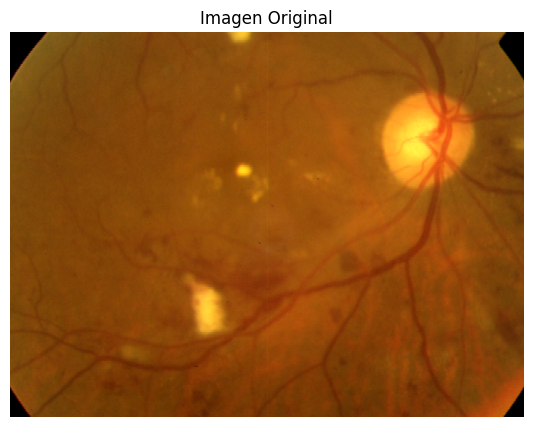

In [3]:
imagen = cv2.imread('/content/dataset/test_images/006efc72b638.png')
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.title("Imagen Original")
plt.imshow(imagen)
plt.axis("off")
plt.show()

# 4. Create new development space with SAM

In [8]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)


mask_generator= SamAutomaticMaskGenerator(model=sam,
    points_per_side=16,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=20000
)
masks = mask_generator.generate(imagen)

#Assign SAM configuration

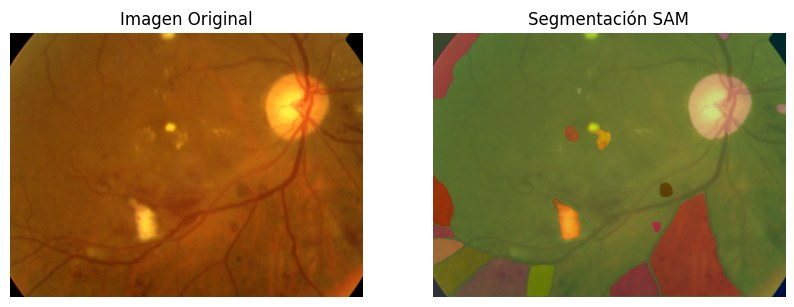

In [9]:
def mostrar_anotaciones(anotaciones):
    if len(anotaciones) > 0:
        anotaciones_ordenadas = sorted(anotaciones, key=(lambda x: x['area']), reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)
        img = np.ones((anotaciones_ordenadas[0]['segmentation'].shape[0], anotaciones_ordenadas[0]['segmentation'].shape[1], 4))
        img[:,:,3] = 0
        for anotacion in anotaciones_ordenadas:
            m = anotacion['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])  # Generar un color aleatorio con una transparencia del 35%
            img[m] = color_mask
        ax.imshow(img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(imagen)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmentación SAM")
plt.imshow(imagen)
mostrar_anotaciones(masks)
plt.axis("off")

plt.show()

#Watershep

In [ ]:
gray = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)

gray = cv2.GaussianBlur(gray, (5, 5), 0)

_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

imagen_watershed = imagen.copy()
cv2.watershed(imagen_watershed, markers)
imagen_watershed[markers == -1] = [255, 0, 0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(imagen)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmentación Watershed")
plt.imshow(imagen_watershed)
plt.axis("off")

plt.show()